**References:** Chapter 17 of Geron's book. For 1-Dim plots, Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder

This file trains a VAE with the instances of the normal digits in the training data. 

Then, it measures the reconstruction loss for the digits in the test data.

The reconstruction loss for the instances of the abnormal digits in the test data is higher.

A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution).  

Then, if the reconstruction loss of a digit in the test data is higher than this threshold, it is classified as abnormal.

By comparing with the known labels of test data (with T for normal digit(s) and F for abnormal digit(s)), the confusion matrix and the accuracy is calculated.

In [5]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.datasets import mnist
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [7]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

**Loading the MNIST data and forming arrays of the normal training data and the test data (normal and abnormal)**

In [8]:
# nl = [0, 1, 2, 3, 4, 5, 6, 7, 9]  # normal digits
abn = 8      # abnormal digit

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

normal_data = x_train[y_train != abn]                   # Normal training data (Normal digits)
normal_labels = y_train[y_train != abn]

test_data = x_test                           # Test data (both normal digits and the abnormal digit)
test_labels = y_test

test_labels_T_F = np.where(test_labels != abn, True, False)
# Array of T and F, T where test digits are normal and F where test digits are abnormal

11501568/11490434 [==============================] - 0s 0us/step


In [9]:
normal_data.shape, test_data.shape, test_labels.shape

((54149, 28, 28), (10000, 28, 28), (10000,))

In [10]:
normal_test_data = test_data[test_labels != abn]                # The normal digits in the test data
abnormal_test_data = test_data[test_labels == abn]              # The abnormal digit in the test data
normal_test_labels = test_labels[test_labels != abn]            # Their labels
abnormal_test_labels = test_labels[test_labels == abn]          # Their labels

In [11]:
normal_test_data.shape, abnormal_test_data.shape 

((9026, 28, 28), (974, 28, 28))

In [12]:
def show_reconstructions(model, images=test_data, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [13]:
K = keras.backend
# def rounded_accuracy(y_true, y_pred):
  #  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [14]:
# For details please see Geron's book. Uses the reparametrization trick to do stochastic 
# sampling from the MVN distribution, while allowing the 2 parallel layers containing the 
# means and stds of the MVN distribution for each dimension to be trained via 
# backpropogation of the error signal.
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [15]:
# For details please see Geron's book. 
codings_size = 16   # The number of dimensions of the MVN distribution in the sampling layer

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(256, activation="selu")(z)
z = keras.layers.Dense(128, activation="selu")(z)
z = keras.layers.Dense(64, activation="selu")(z)

# Parallel layers at the end of the encoder for means 
# and standard deviations of the Multivariate Normal (MVN) distribution 
# in the dimensions of the coding size (here 32). 
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)

# Sampling layer at the end of the encoder
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(64, activation="selu")(decoder_inputs)
x = keras.layers.Dense(128, activation="selu")(x)
x = keras.layers.Dense(256, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# The latent loss function
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)

# Add the latent loss to the reconstruction loss
variational_ae.add_loss(K.mean(latent_loss) / 784.)

# For the reconstruction loss binary cross-entropy loss is used. 
# For details please see Chapter 17 of Geron's book (Stacked AE and VAE sections) 
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")
history = variational_ae.fit(normal_data, normal_data, epochs=100, batch_size=128,
                             validation_data=(normal_test_data, normal_test_data), shuffle=True)

Epoch 1/100
424/424 [==============================] - 10s 12ms/step - loss: 0.2214 - val_loss: 0.2024
Epoch 2/100
424/424 [==============================] - 4s 10ms/step - loss: 0.1680 - val_loss: 0.1721
Epoch 3/100
424/424 [==============================] - 4s 10ms/step - loss: 0.1561 - val_loss: 0.1644
Epoch 4/100
424/424 [==============================] - 4s 10ms/step - loss: 0.1504 - val_loss: 0.1573
Epoch 5/100
424/424 [==============================] - 4s 10ms/step - loss: 0.1468 - val_loss: 0.1599
Epoch 6/100
424/424 [==============================] - 4s 10ms/step - loss: 0.1443 - val_loss: 0.1517
Epoch 7/100
424/424 [==============================] - 4s 11ms/step - loss: 0.1425 - val_loss: 0.1528
Epoch 8/100
424/424 [==============================] - 4s 10ms/step - loss: 0.1410 - val_loss: 0.1495
Epoch 9/100
424/424 [==============================] - 4s 10ms/step - loss: 0.1398 - val_loss: 0.1533
Epoch 10/100
424/424 [==============================] - 4s 10ms/step - loss: 0.13

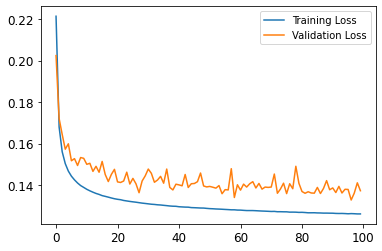

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

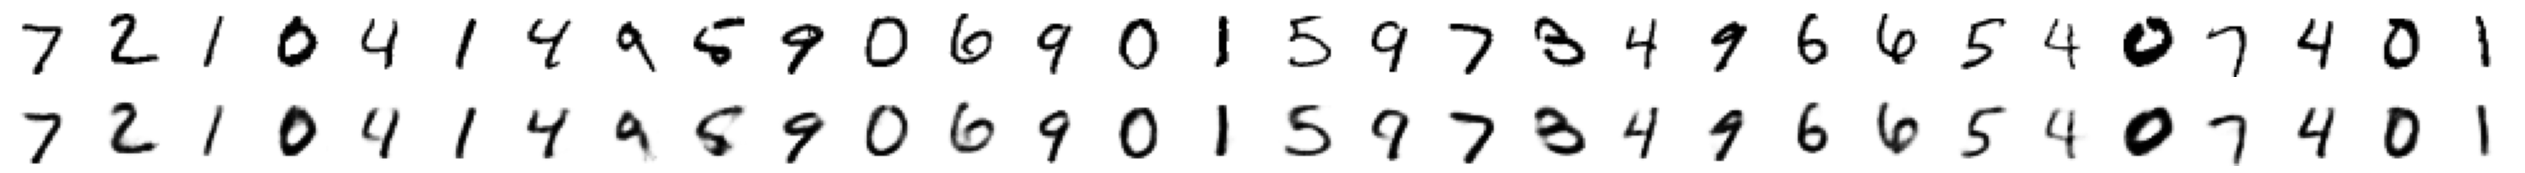

In [17]:
show_reconstructions(variational_ae, test_data, 30)
plt.show()

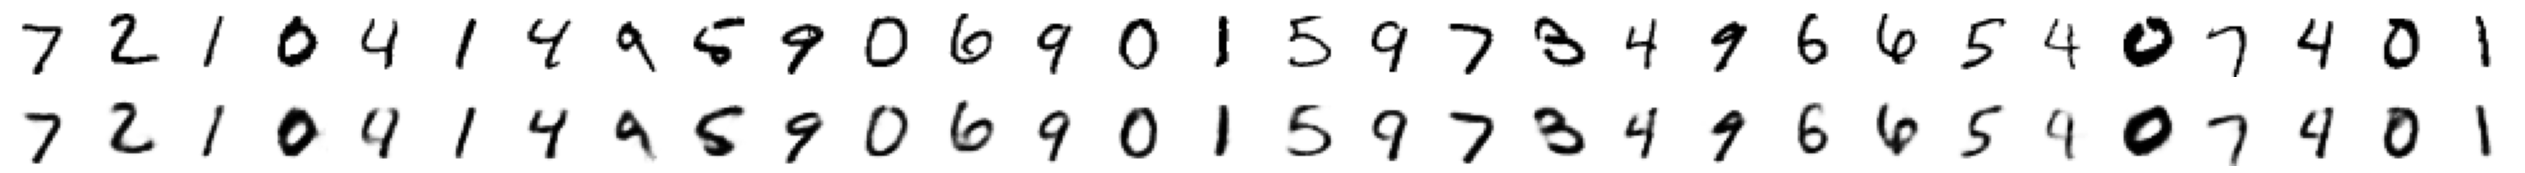

In [18]:
show_reconstructions(variational_ae, normal_test_data, 30)
plt.show()

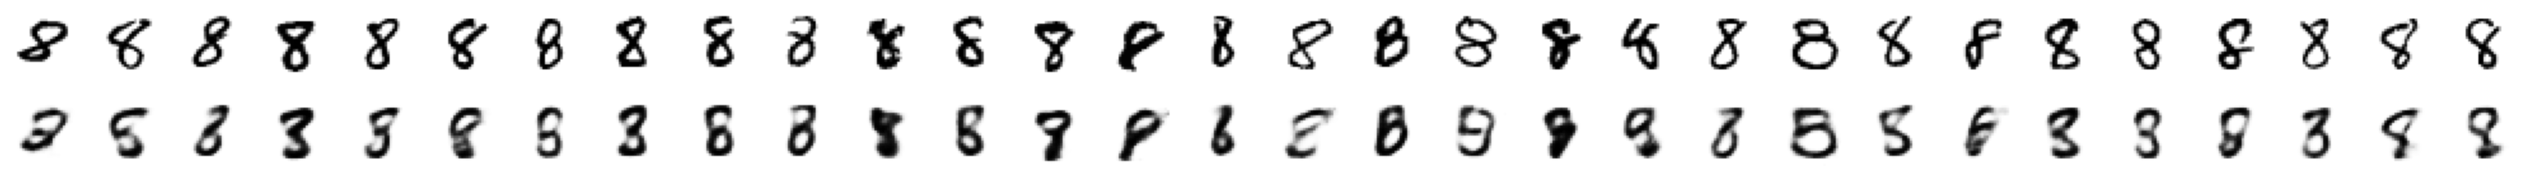

In [19]:
show_reconstructions(variational_ae, abnormal_test_data, 30)
plt.show()

In [20]:
reconstructions_nl_test = variational_ae.predict(normal_test_data)

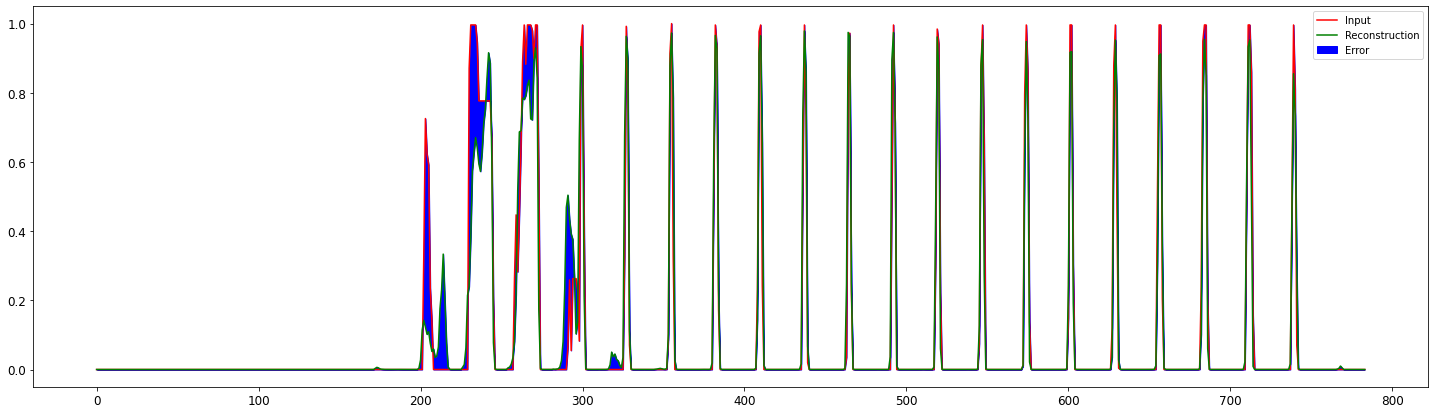

In [21]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(reconstructions_nl_test[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), reconstructions_nl_test[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [22]:
reconstructions_abn_test = variational_ae.predict(abnormal_test_data)

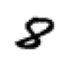

In [23]:
plt.figure(figsize=(1,1))
plt.imshow(abnormal_test_data[0], cmap="binary")
plt.axis('off')
plt.show()

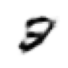

In [24]:
plt.figure(figsize=(1,1))
plt.imshow(reconstructions_abn_test[0], cmap="binary")
plt.axis('off')
plt.show()

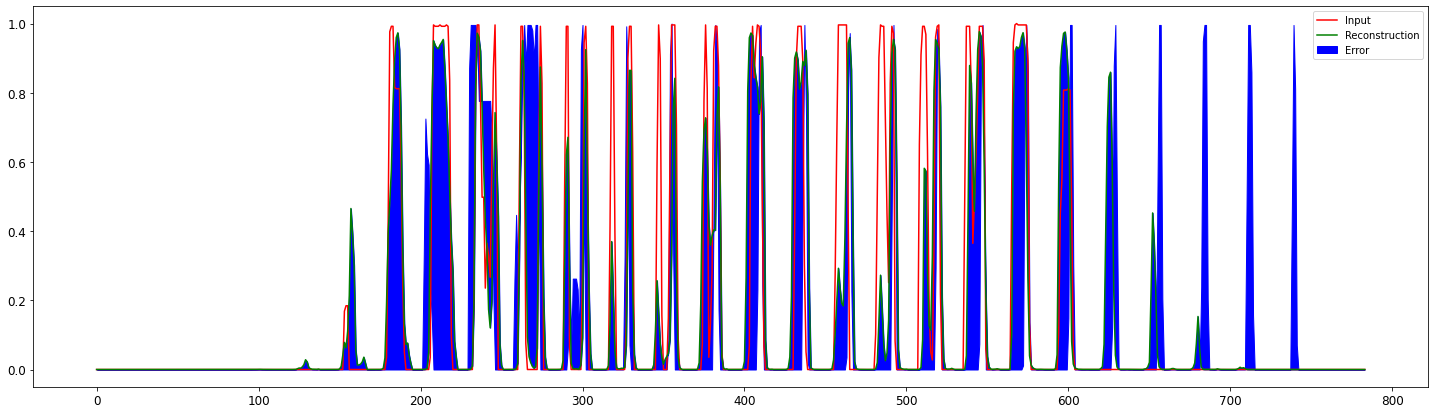

In [25]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(reconstructions_abn_test[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), reconstructions_abn_test[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

**Distribution of the reconstruction losses of the normal training data**

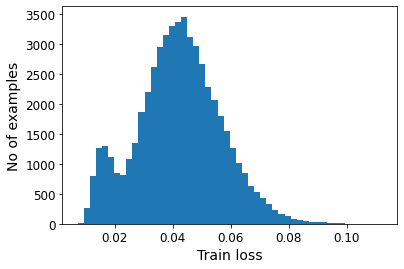

In [26]:
reconstructions_nl_data = variational_ae.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions_nl_data.reshape(-1, 784), normal_data.reshape(-1, 784))
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [27]:
print("Mean: ", np.mean(train_loss))
print("Std: ", np.std(train_loss))

Mean:  0.042015888
Std:  0.014556731


In [28]:
threshold1 = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold1: ", threshold1)

Threshold1:  0.07840771554037929


**Distribution of the reconstruction losses of the abnormal test data**

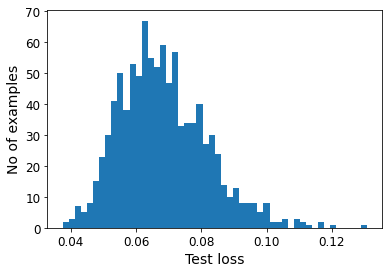

In [29]:
abn_test_loss = tf.keras.losses.mae(reconstructions_abn_test.reshape(-1,784), abnormal_test_data.reshape(-1,784))

plt.hist(abn_test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [30]:
# threshold2 = np.mean(abn_test_loss) - np.std(abn_test_loss)
# print("Threshold2: ", threshold2)

In [31]:
np.mean(abn_test_loss) , np.std(abn_test_loss)

(0.06835322, 0.013445512)

**Threshold will be threshold1 = mean + std of the distribution of the reconstruction losses of the normal training data**

In [32]:
threshold = threshold1

**Calculation of the confusion matrix**

In [33]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [34]:
preds = predict(variational_ae, test_data, threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             310   9690
 label: F   [[191   783]    974
        T    [119   8907]]   9026
Accuracy = 0.9098
Precision = 0.9191950464396285
Recall = 0.9868158652780855


In [35]:
print(confusion_matrix(test_labels_T_F, preds))

[[ 191  783]
 [ 119 8907]]


**Distribution of the reconstruction losses of the test data (normal and abnormal)**

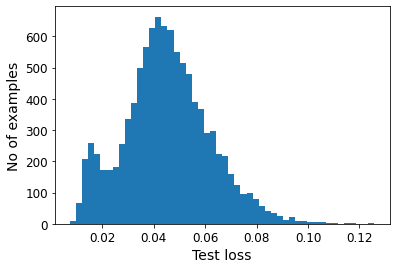

In [36]:
reconstructions_test_data = variational_ae.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions_test_data.reshape(-1,784), test_data.reshape(-1,784))

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [37]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

**Extra Info**

Giving the VAE codings (please see book) (Just informative, not the goal here)

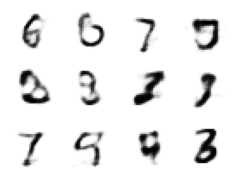

In [38]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
# save_fig("vae_generated_images_plot", tight_layout=False)

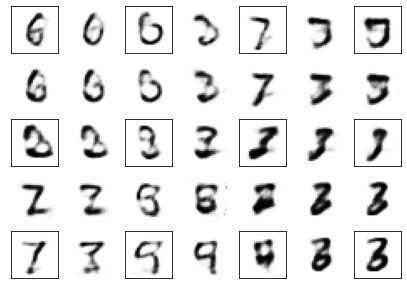

In [39]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
# save_fig("semantic_interpolation_plot", tight_layout=False)